In [2]:
import numpy as np
import math
from scipy.integrate import ode
import Kep_2_Cart, Cart_2_Kep
from mpl_toolkits.basemap import Basemap
import filter_functions
import scipy
import scipy.io
import pickle
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

#from mpl_toolkits.basemap import Basemap

%matplotlib inline
plt.rcParams['figure.figsize'] = (13.0, 4.0)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
np.set_printoptions(precision=15)


earth_radius = 6378136.3*1e-3 #km
e_earth = .081819221456 
omega_const = 7.2921158553e-5


#Date of Simulation Details:
#June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
year = 2017
month = 6
day = 24
hour_init = 6
boulder_UT_offset = 6 #Boulder time + 6 hours = UT time
hour_init_UT = hour_init + boulder_UT_offset

In [3]:
#input the ecef x, y, z position of a space obj in order to calculate
#the lat, lon, (radians) and alt of a space obj
def ecef2geo_lat_lon_alt(r_ecef, main_body_radius):
    r = np.linalg.norm(r_ecef)
    altitude = r - main_body_radius
    
    x, y, z = r_ecef.reshape(3, 1)
    latitude = math.asin(z/r)
    
    longitude = math.atan2(y, x)
    #check by using eq. for x
    #x_calc = r*math.cos(latitude)*math.cos(longitude)
    #print(x_calc - x)
    return (latitude, longitude, altitude)

In [4]:
#Read in True Orbit



truth_file_const = open('Data Files/meas_az_el_range_constDensity.pkl', 'rb')
mydict_const = pickle.load(truth_file_const)
truth_file_const.close()
measurement_array_const = mydict_const['measurement_array']
truth_xyz_const = mydict_const['truth_pos_vel']
print(np.shape(truth_xyz_const))
pos_array_const = truth_xyz_const[:, 0:3]
density_const = mydict_const['true_density']



stop_index = len(measurement_array_const)

(721, 6)


In [5]:
#loop and calc lat, lon



lon_array = np.zeros(stop_index)
lat_gd_array = np.zeros(stop_index)

delta_t = 10

for ii in range(stop_index):

    r_eci = pos_array_const[ii, :]
    
    #Calculations for theta_gmst (rotation btwn ECI & ECEF for the current time of simulation/orbit)--------------
    hour = hour_init_UT + delta_t/(60*60) #hours (float) since midnight UT
    jd = filter_functions.calc_julian_date(year, month, day, hour) #date of interest in UT

    T_UT = (jd - 2451545)/36525 #calc T_UT at this delta_t/date 
    #calculate theta gmst @ 0 hr using the T_UT and the eq. from Vallado 
    theta_gmst_0_hr = math.radians(100.4606184 + 36000.77005361*T_UT + \
                                           .00038793*T_UT**2 - 2.6e-8*T_UT**3)
    seconds = hour * 60 * 60 #seconds since midnight UT 
    #calculate theta gmst using theta gmst @ 0 hr and seconds 
    #since midnight*the rotation rate of earth
    theta_gmst = theta_gmst_0_hr + omega_const * seconds 
    theta_gmst = theta_gmst % (2*math.pi)
        
    
    r_ecef = filter_functions.eci2ecef(r_eci, theta_gmst)
    

    #step f
    latitude, longitude, altitude = ecef2geo_lat_lon_alt(r_ecef, earth_radius)
    
    #step g
    latitude_geodetic = math.atan2(math.tan(latitude), 1-e_earth**2)

    lon_array[ii] = longitude
    lat_gd_array[ii] = latitude_geodetic
    
    delta_t = delta_t + 10

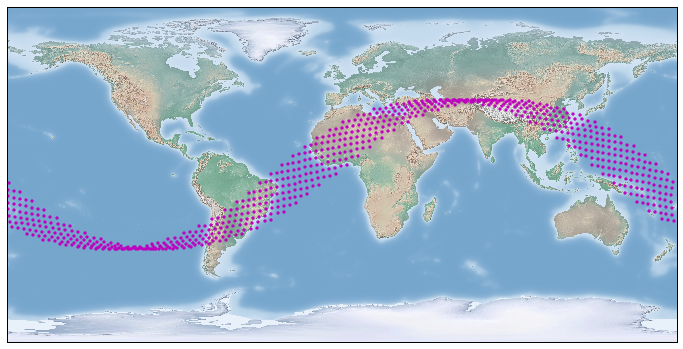

In [6]:


fig = plt.figure(figsize=(12,8))
#create simple basemap obj
m = Basemap()
# add coastlines to basemap
#m.drawcoastlines()
m.shadedrelief()
#plot the groudtrack (lat & lon values) on basemap 
m.scatter(np.degrees(lon_array), np.degrees(lat_gd_array), marker='.', color='m')
#m.scatter(np.degrees(lon_array[:stop_index/2]), np.degrees(lat_gd_array[:stop_index/2]), marker='.', color='m')
#m.scatter(np.degrees(lon_array[stop_index/2:]), np.degrees(lat_gd_array[stop_index/2:]), marker='.', color='g')

fig.savefig('Figures/GroundTrack_const.png')

In [7]:
fig.savefig('Figures/GroundTrack_constDensity.png')

In [8]:
#Read in True Orbit

truth_file_complex = open('Data Files/meas_az_el_range_complexDensity.pkl', 'rb')
mydict_complex = pickle.load(truth_file_complex)
truth_file_complex.close()
measurement_array_complex = mydict_complex['measurement_array']
truth_xyz_complex = mydict_complex['truth_pos_vel']
print(np.shape(truth_xyz_complex))
pos_array_complex = truth_xyz_complex[:, 0:3]
density_complex = mydict_complex['true_density']


(721, 6)


In [9]:
#loop and calc lat, lon


lon_array = np.zeros(stop_index)
lat_gd_array = np.zeros(stop_index)

delta_t = 10

for ii in range(stop_index):

    r_eci = pos_array_complex[ii, :]
    
    #Calculations for theta_gmst (rotation btwn ECI & ECEF for the current time of simulation/orbit)--------------
    hour = hour_init_UT + delta_t/(60*60) #hours (float) since midnight UT
    jd = filter_functions.calc_julian_date(year, month, day, hour) #date of interest in UT

    T_UT = (jd - 2451545)/36525 #calc T_UT at this delta_t/date 
    #calculate theta gmst @ 0 hr using the T_UT and the eq. from Vallado 
    theta_gmst_0_hr = math.radians(100.4606184 + 36000.77005361*T_UT + \
                                           .00038793*T_UT**2 - 2.6e-8*T_UT**3)
    seconds = hour * 60 * 60 #seconds since midnight UT 
    #calculate theta gmst using theta gmst @ 0 hr and seconds 
    #since midnight*the rotation rate of earth
    theta_gmst = theta_gmst_0_hr + omega_const * seconds 
    theta_gmst = theta_gmst % (2*math.pi)
        
    
    r_ecef = filter_functions.eci2ecef(r_eci, theta_gmst)
    

    #step f
    latitude, longitude, altitude = ecef2geo_lat_lon_alt(r_ecef, earth_radius)
    
    #step g
    latitude_geodetic = math.atan2(math.tan(latitude), 1-e_earth**2)

    lon_array[ii] = longitude
    lat_gd_array[ii] = latitude_geodetic
    
    delta_t = delta_t + 10

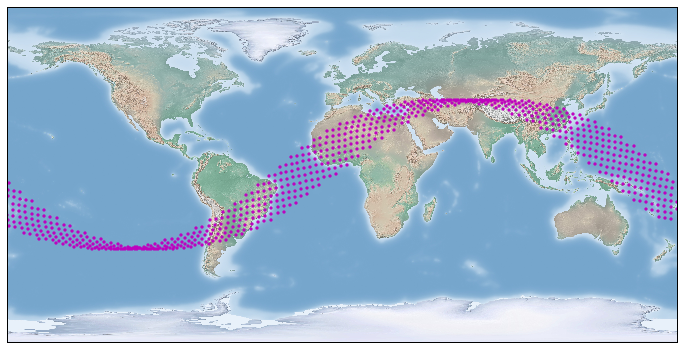

In [10]:


fig = plt.figure(figsize=(12,8))
#create simple basemap obj
m = Basemap()
# add coastlines to basemap
#m.drawcoastlines()
m.shadedrelief()
#plot the groudtrack (lat & lon values) on basemap 
m.scatter(np.degrees(lon_array), np.degrees(lat_gd_array), marker='.', color='m')
#m.scatter(np.degrees(lon_array[:stop_index/2]), np.degrees(lat_gd_array[:stop_index/2]), marker='.', color='m')
#m.scatter(np.degrees(lon_array[stop_index/2:]), np.degrees(lat_gd_array[stop_index/2:]), marker='.', color='g')

fig.savefig('Figures/GroundTrack_complex.png')

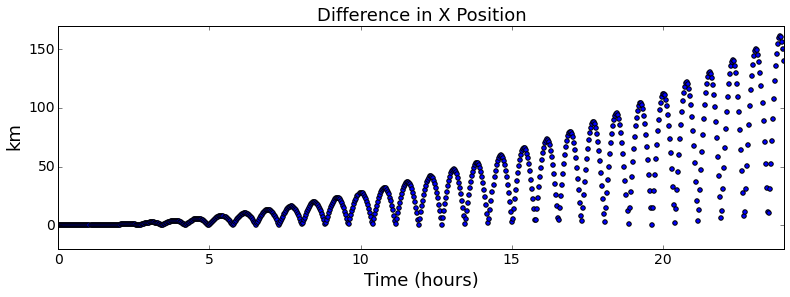

In [11]:
x_diff = np.absolute(truth_xyz_complex[:,0] - truth_xyz_const[:,0])
y_diff = np.absolute(truth_xyz_complex[:,1] - truth_xyz_const[:,1])/truth_xyz_complex[:,0] 
z_diff = np.absolute(truth_xyz_complex[:,2] - truth_xyz_const[:,2])/truth_xyz_complex[:,0] 


fig_xpos = plt.figure()
plt.scatter(measurement_array_complex[:,0]/(60*60), x_diff*1e-3)
plt.ylabel('km', fontsize=18)
plt.xlabel('Time (hours)', fontsize=18)
plt.ylim([-20, 170])
plt.xlim([measurement_array_complex[0,0]/(60*60), measurement_array_complex[-1,0]/(60*60)])
plt.title('Difference in X Position', fontsize=18)
plt.show()

fig_xpos.savefig('Figures/xpos_diff.png')

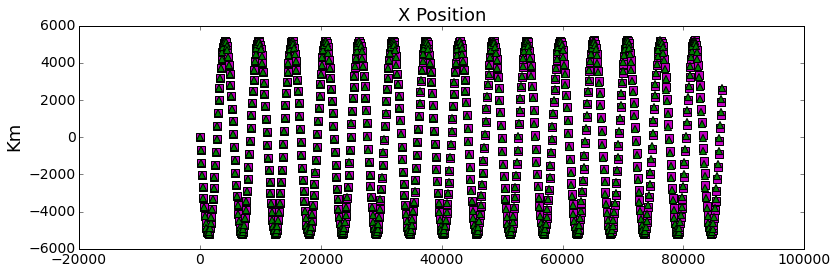

In [12]:
fig_percent = plt.figure()
plt.scatter(measurement_array_complex[:,0], truth_xyz_complex[:,0]*1e-3, s=50, c='m', marker='s')
plt.scatter(measurement_array_complex[:,0], truth_xyz_const[:,0]*1e-3, s=50, c='g', marker='^')
plt.ylabel('Km', fontsize=18)
plt.xlabel('', fontsize=18)
plt.title('X Position', fontsize=18)
plt.show()

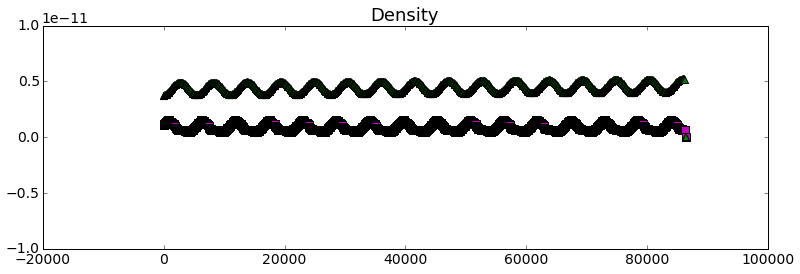

In [13]:
plt.scatter(measurement_array_complex[:,0], density_complex, s=50, c='m', marker='s')
plt.scatter(measurement_array_complex[:,0], density_const, s=50, c='g', marker='^')
plt.ylabel('', fontsize=18)
plt.xlabel('', fontsize=18)
plt.title('Density', fontsize=18)
plt.ylim([-1e-11,1e-11])
plt.show()

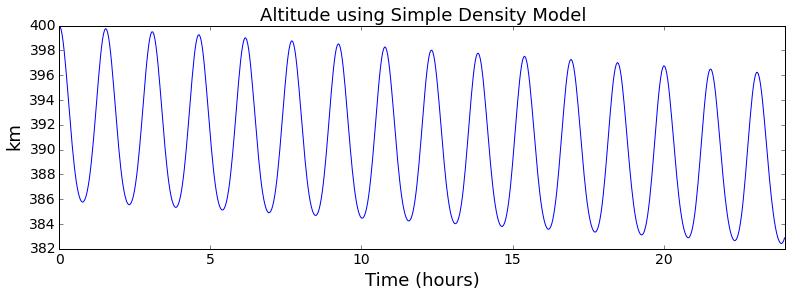

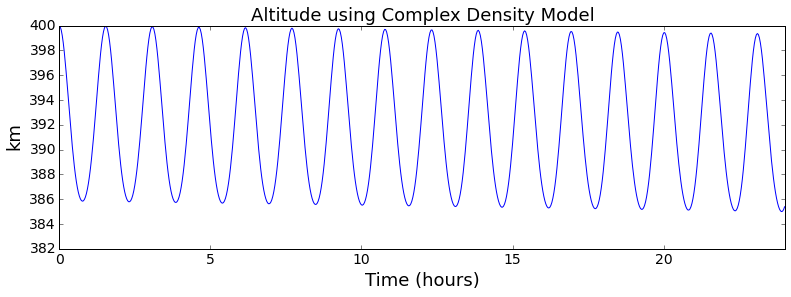

In [14]:
indices = np.arange(0,stop_index,1)


range_const_array = np.zeros((stop_index,1))
range_complex_array = np.zeros((stop_index,1))


for ii in range(stop_index):
    
    range_const_array[ii,0] = (np.linalg.norm(truth_xyz_const[ii,:3])- earth_radius*1e3)*1e-3
    
    range_complex_array[ii,0] = (np.linalg.norm(truth_xyz_complex[ii,:3])- earth_radius*1e3)*1e-3
    
fig_simple_alt = plt.figure()
plt.plot(measurement_array_complex[indices,0]/(60*60), range_const_array[indices,0])
plt.ylabel('km', fontsize=18)
plt.xlabel('Time (hours)', fontsize=18)
plt.ylim([382, 400])
plt.xlim([measurement_array_complex[0,0]/(60*60), measurement_array_complex[-1,0]/(60*60)])
plt.title('Altitude using Simple Density Model', fontsize=18)
#plt.ylim([-1e-11,1e-11])
plt.show()

fig_simple_alt.savefig('Figures/simple_alt.png')


fig_complex_alt = plt.figure()
plt.plot(measurement_array_complex[indices,0]/(60*60), range_complex_array[indices,0])
plt.ylabel('km', fontsize=18)
plt.xlabel('Time (hours)', fontsize=18)
plt.ylim([382, 400])
plt.xlim([measurement_array_complex[0,0]/(60*60), measurement_array_complex[-1,0]/(60*60)])
plt.title('Altitude using Complex Density Model', fontsize=18)
#plt.ylim([-1e-11,1e-11])
plt.show()

fig_complex_alt.savefig('Figures/complex_alt.png')